# Procedure 
### part I and part II
1. Data exploration & visualization 
2. Holdout (splitting data) 
3. SelectKbest 
     - gridsearchCV 
     - Decision tree model
         + Cross validation
         + Confusion matrix
         + Classification_report
     - Random forest model 
         + Cross validation (not sure)
         + Confusion matrix 
         + Classification_report 

### part III
4. PCA
     - gridsearchCV
     - Decision tree model
         + Cross validation
         + Confusion matrix
         + Classification_report
     - Random forest model
         + Cross validation
         + Confusion matrix
         + Classification_report
5. Do the write-up analysis and conclusions, make sure that you include time execution for the models.

ref:
https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

# Part I
selectKbest, Randomforest

### 0. Load data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Here we'll use data from Lending Club (2015) to predict the state of a loan given some information about it. You can download the dataset [here](https://www.dropbox.com/s/0so14yudedjmm5m/LoanStats3d.csv?dl=1)

In [2]:
# Replace the path with the correct path for your data.
y2015 = pd.read_csv(
#     'https://www.dropbox.com/s/0so14yudedjmm5m/LoanStats3d.csv?dl=1',
    './LoanStats3d.csv',
    skipinitialspace=True,
    header=1
)

# Note the warning about dtypes.

C:\Users\kefei\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (0,19,55) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# y2015.head()

### 1. EDA
##### data cleaning
- This dataset has 100+ non-null columns, 400,000+ non-null records. 
- For the first atempt, we can just drop all the columns with null values, instead of imputation.
- Note that, the afformentioned strategy is for numerical features; for categorical features, the null values can be handeled by using one-hot-encoding.
- Also note that, in order to make the training set and test set have same features, we will first split the data into training set and test set, then perform one-hot-encoding and dropna.
#### data exploration
- The target is categorical, we are working on classification problem. So, we use bar plot to show the number of each categories. (It might raise some concern if the number of each categories are too unbalanced)
- For each feature, since there are too many, it is very hard to plot them all or analyze individual feature. Later on we will use SelectKbest method for feature engineering.

In [4]:
# 'object' type data info
df_object = y2015.select_dtypes(include=['object'])
# print(df_object.info())

# 'float' type data info
df_float = y2015.select_dtypes(include=['float'])
# print(df_float.info())

#### The dataset is kind of big for training, especially for gridsearchCV. For practice purpose, we will cut the data into 10,000 records. 

In [5]:
# cut the data to the first 10,000 records
y2015 = y2015[:10001]
y2015.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001 entries, 0 to 10000
Columns: 111 entries, id to total_il_high_credit_limit
dtypes: float64(85), object(26)
memory usage: 8.5+ MB


In [6]:
# Remove two summary rows at the end that don't actually contain data.
# y2015 = y2015[:-2]



# Convert ID and Interest Rate to numeric.
y2015['id'] = pd.to_numeric(y2015['id'], errors='coerce')
y2015['int_rate'] = pd.to_numeric(y2015['int_rate'].str.strip('%'), errors='coerce')


# explore columns with nan falues
null_col_list = []
for col in y2015.columns:
    if y2015[col].isna().any():
        null_col_list.append(col)
        
null_col_list
# len(null_col_list)
y2015[null_col_list].info()

# in this dataset, since we already have a lot of columns, we can drop all the columns with nan instead of imputation.
# df = y2015.drop(null_col_list, axis = 1)
df= y2015.copy()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001 entries, 0 to 10000
Data columns (total 36 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   emp_title                       9444 non-null   object 
 1   emp_length                      9452 non-null   object 
 2   desc                            1 non-null      object 
 3   title                           9869 non-null   object 
 4   mths_since_last_delinq          5200 non-null   float64
 5   mths_since_last_record          1778 non-null   float64
 6   revol_util                      9996 non-null   object 
 7   last_pymnt_d                    9994 non-null   object 
 8   next_pymnt_d                    8189 non-null   object 
 9   mths_since_last_major_derog     2926 non-null   float64
 10  annual_inc_joint                65 non-null     float64
 11  dti_joint                       65 non-null     float64
 12  verification_status_joint       

In [7]:
# get dummy, but be careful not make too large a dummy dataset, drop those columns with too many categories (>80)
df_object = df.select_dtypes(include='object')
col_drop_list = []
for col in df_object.columns:
#     column = df_object[i]
    print(col)
    print(df_object[col].nunique())
    if df_object[col].nunique() > 80:
        col_drop_list.append(col)
        
# col_drop_list
# type(df_object[i])

df = df.drop(col_drop_list, axis = 1)
df.info()

# # make dummy
# df_dummy = pd.get_dummies(df)
# df_dummy.info()

term
2
grade
7
sub_grade
35
emp_title
5621
emp_length
11
home_ownership
3
verification_status
3
issue_d
1
loan_status
7
pymnt_plan
1
url
10001
desc
1
purpose
12
title
12
zip_code
789
addr_state
49
earliest_cr_line
504
revol_util
1025
initial_list_status
2
last_pymnt_d
14
next_pymnt_d
2
last_credit_pull_d
14
application_type
2
verification_status_joint
3
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001 entries, 0 to 10000
Columns: 106 entries, id to total_il_high_credit_limit
dtypes: float64(86), int64(1), object(19)
memory usage: 8.1+ MB


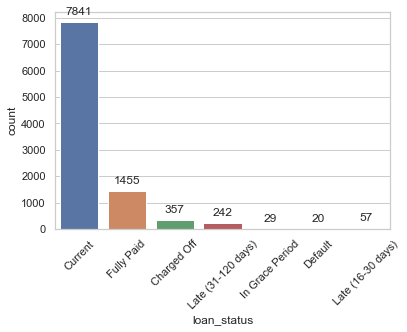

In [8]:
df['loan_status'].value_counts()

import seaborn as sns

sns.set(style="whitegrid")
splot = sns.countplot(x="loan_status",data=df[['loan_status']])
plt.xticks(rotation = 45)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., 
                    p.get_height()), 
                   ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

### 2. Split

In [9]:
from sklearn.model_selection import train_test_split

X = df.drop('loan_status', axis=1)
X = pd.get_dummies(X)
X = X.dropna(axis=1)
y = df['loan_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)



### baseline prediction
Make a wild guess, all the loan status is current, check the accuracy under such prediction. Our model performance should outweight that at least.

In [10]:
print(y_test.value_counts())
print(y_test.count())
print('-------------------')
print('baseline accuracy: {}'.format(y_test[y_test=='Current'].count()/y_test.count()))


Current               1578
Fully Paid             278
Charged Off             85
Late (31-120 days)      38
Late (16-30 days)       11
In Grace Period          8
Default                  3
Name: loan_status, dtype: int64
2001
-------------------
baseline accuracy: 0.7886056971514243


### 3. select K best, gridSearch 

# part III
feature enineering using PCA, then perform random forest and decision tree classification again.

ref: https://www.codementor.io/@divyeshaegis/when-to-use-pca-before-or-after-a-train-test-split-vxdrlu6ci

### recall
- We will use the same dataset, same features, same training and test data as random forest model
- Also, recall the baseline accuracy is 0.7886
- So, we will start from feature engineering (PCA)

In [11]:
# for convenience repeat here
# from sklearn.model_selection import train_test_split

X = df.drop('loan_status', axis=1)
X = pd.get_dummies(X)
X = X.dropna(axis=1)
y = df['loan_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### It is widely accepted that PCA does not work well on categorical / binary type of data, so we only perform PCA on continous data. For the rest it, we will use selectKBest

In [12]:
# 'object' type data info
pca_list = []
for col in X_train.columns:
#     print(X_train[col].nunique())
    if X_train[col].nunique() > 2:
        pca_list.append(col)

In [13]:
X_train_continous = X_train.loc[:,pca_list]
X_test_continous = X_test.loc[:,pca_list]
# X_train_continous

In [14]:
encoding_list = [item for item in list(X_train.columns) if item not in pca_list]
X_train_encoding = X_train.loc[:,encoding_list]
X_test_encoding = X_test.loc[:,encoding_list]
# X_train_encoding

In [15]:
# perform standard scalar normalization to normalize our feature set
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train_stdscaler = sc.fit_transform(X_train_continous)
X_test_stdscaler = sc.transform(X_test_continous)

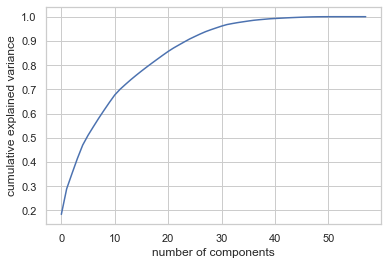

In [16]:
# Applying PCA
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X_train_stdscaler)

# plot
explained_variance = pca.explained_variance_ratio_
explained_variance
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [17]:
pca = PCA(n_components=30)

X_train_continous = pca.fit_transform(X_train_stdscaler)
X_test_continous = pca.transform(X_test_stdscaler)

In [18]:
# X_train_continous.shape

#### selectKbest

In [21]:
# using chi-squre to select the top 200 features.
from sklearn.feature_selection import SelectKBest, chi2

#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k="all")
fit = bestfeatures.fit(X_train_encoding,y_train)

dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X_train_encoding.columns)
dftypes = pd.DataFrame(X_train_encoding.dtypes.values)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores, dftypes],axis=1)
# featureScores['dftypes'] = dftypes
featureScores.columns = ['Specs','Score','dftypes']  #naming the dataframe columns


# print(featureScores.nlargest(50,'Score'))


In [22]:
# take the K best score (k = 20)
take_k = 20
X_train_KBest = X_train[featureScores.nlargest(take_k,'Score')['Specs'].values].copy()
# X_train_KBest

X_test_KBest = X_test[X_train_KBest.columns].copy()
# X_test_KBest


In [23]:
pd.DataFrame(X_train_continous)

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,6.428269,2.682757,2.250459,-9.312073,2.971323,0.415720,-1.793188,-0.414958,-0.453025,-0.175108,...,-0.348766,-0.275914,-0.092422,-0.837167,0.580818,0.826244,0.066083,1.204048,0.066523,-0.054457
1,-1.391119,0.067291,-2.080221,-0.379658,-1.292835,-0.972226,0.075935,0.057728,-0.057285,0.752842,...,-0.269469,0.259114,0.165412,0.457707,-0.619293,-0.394920,0.674820,0.759123,0.028391,0.820715
2,4.320306,-5.650859,-1.901587,-0.833684,2.384689,0.281163,-0.046731,0.101987,0.229895,-0.040157,...,0.365406,0.145827,0.480210,-1.067330,-0.087290,0.056452,-0.469957,-0.251549,0.700647,-0.580994
3,2.928293,1.632387,4.603475,-4.587686,-0.836109,1.631153,-0.324824,-0.197627,-0.342595,-0.774270,...,0.571459,1.327825,-1.142450,1.405766,0.052926,-0.133125,0.592025,1.315632,-0.752020,0.945775
4,-1.138958,-1.249282,-0.490809,-0.088124,1.537640,0.867687,0.470345,0.068449,-0.063009,-0.312089,...,0.188642,-0.323703,0.473910,-0.757480,-0.177895,-0.182224,0.002917,-0.083622,-0.595318,-0.598485
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,0.630008,-2.359242,-2.079336,-0.958393,1.207036,0.751682,0.969271,-0.037004,-0.377920,0.011414,...,-0.143486,-1.038564,3.002011,-0.510472,-1.187903,-0.424950,-1.101283,-1.159963,0.891244,0.302409
7996,-1.707168,-1.098791,1.328928,-2.665047,-0.846321,0.374110,-1.220295,-0.334198,0.011252,-0.186074,...,-0.091653,-0.033982,-0.077052,0.562078,-0.456623,0.736116,-0.336436,0.452348,-0.410602,0.046371
7997,-1.042150,0.763288,2.602068,-1.840042,1.778293,-0.919254,-1.283691,-0.344462,-0.429570,-0.299508,...,0.397984,0.757398,-0.209124,0.027230,0.881597,-0.275381,0.333405,0.803787,0.169371,-0.234275
7998,7.238560,-1.005207,-3.600543,0.788218,0.171085,0.809020,-1.355754,-0.205062,0.021187,-0.166344,...,0.048308,-0.088603,-0.388497,-1.809741,1.316909,-1.393719,0.675647,0.775134,-0.327783,0.136387


In [24]:
X_train_KBest.values

array([[0, 0, 0, ..., 0, 0, 1],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 1, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [27]:
X_train_pca = pd.concat([pd.DataFrame(X_train_continous), 
                         pd.DataFrame(X_train_KBest.values)],axis=1)

X_test_pca = pd.concat([pd.DataFrame(X_test_continous), 
                         pd.DataFrame(X_test_KBest.values)],axis=1)


X_train_pca

,0,1,2,3,4,5,6,7,8,9,...,10,11,12,13,14,15,16,17,18,19
0,6.428269,2.682757,2.250459,-9.312073,2.971323,0.415720,-1.793188,-0.414958,-0.453025,-0.175108,...,0,0,0,0,0,0,0,0,0,1
1,-1.391119,0.067291,-2.080221,-0.379658,-1.292835,-0.972226,0.075935,0.057728,-0.057285,0.752842,...,0,0,0,1,0,0,0,0,0,0
2,4.320306,-5.650859,-1.901587,-0.833684,2.384689,0.281163,-0.046731,0.101987,0.229895,-0.040157,...,0,0,0,1,0,0,0,0,0,0
3,2.928293,1.632387,4.603475,-4.587686,-0.836109,1.631153,-0.324824,-0.197627,-0.342595,-0.774270,...,0,0,1,0,0,0,0,0,0,0
4,-1.138958,-1.249282,-0.490809,-0.088124,1.537640,0.867687,0.470345,0.068449,-0.063009,-0.312089,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,0.630008,-2.359242,-2.079336,-0.958393,1.207036,0.751682,0.969271,-0.037004,-0.377920,0.011414,...,1,0,0,1,0,0,0,0,0,0
7996,-1.707168,-1.098791,1.328928,-2.665047,-0.846321,0.374110,-1.220295,-0.334198,0.011252,-0.186074,...,0,0,0,0,0,0,0,0,0,0
7997,-1.042150,0.763288,2.602068,-1.840042,1.778293,-0.919254,-1.283691,-0.344462,-0.429570,-0.299508,...,0,0,1,0,0,0,0,0,1,0
7998,7.238560,-1.005207,-3.600543,0.788218,0.171085,0.809020,-1.355754,-0.205062,0.021187,-0.166344,...,0,0,0,1,0,0,0,0,0,0


In [30]:
# fast check if taking k feature is sactifactory using default hyperparameters
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

dtc = DecisionTreeClassifier()
rfc = RandomForestClassifier()

cross_val_score(rfc, X_train_pca, y_train, cv=5, verbose=1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    9.1s finished


array([0.978125, 0.97625 , 0.98125 , 0.980625, 0.981875])

### Grid Search with Cross Validation
- Decision tree model is less complex than random forest, and also faster
- So, we jump into grid search CV for decision tree's hyper parameter search.

In [32]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 

    
param_grid = {
    'criterion': ['entropy', 'gini'],
    'max_depth': [10, 20, 50, 100, None],
    'min_samples_leaf': [1, 2],
    'min_samples_split': range(1, 10)
    
}
# Create a based model
dtc = DecisionTreeClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = dtc, param_grid = param_grid, 
                          cv = 10, n_jobs = -1, verbose = 0)


# Fit the random search model
_ = grid_search.fit(X_train_pca, y_train)

In [33]:
print(grid_search.best_params_)
print('-------------------------------------')
print(grid_search.best_score_)
print('-------------------------------------')
print(grid_search.best_estimator_)
print('-------------------------------------')
# print(grid_search.cv_results_)
result_dtc_grid = grid_search.cv_results_

{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 9}
-------------------------------------
0.9742500000000002
-------------------------------------
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=9,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
-------------------------------------


In [34]:
#concat two dataframes for better visualization 
df_result_grid2 = pd.concat([pd.DataFrame(result_dtc_grid['mean_fit_time']),
                              pd.DataFrame(result_dtc_grid['mean_test_score'])],axis=1)

df_result_grid2.columns = ['mean_fit_time','mean_test_score']  #naming the dataframe columns
df_result_grid2['accuracy_time_ratio'] = df_result_grid2['mean_test_score']/df_result_grid2['mean_fit_time']
df_result_grid2['params'] = result_dtc_grid['params']


In [39]:
# Grid search cv result sumary
index_accuracy = df_result_grid2['mean_test_score'].idxmax()
index_ratio = df_result_grid2['accuracy_time_ratio'].idxmax()
print("Highest accuracy model is: NO. {}: \n {}".format(index_accuracy, 
                                                     df_result_grid2['params'][index_accuracy]))
print("Highest accuracy-time ratio model is: NO. {}: \n {}".format(index_ratio, 
                                                     df_result_grid2['params'][index_ratio]))


Highest accuracy model is: NO. 17: 
 {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 9}
Highest accuracy-time ratio model is: NO. 105: 
 {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 7}


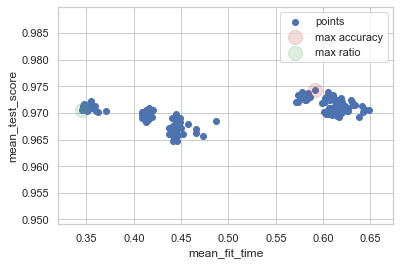

In [41]:
# visualize the cv result

plt.scatter(df_result_grid2['mean_fit_time'], df_result_grid2['mean_test_score'], c='b', label="points")
plt.scatter(df_result_grid2['mean_fit_time'][index_accuracy], df_result_grid2['mean_test_score'][index_accuracy], c='r', s=200, alpha=0.2, label='max accuracy')
plt.scatter(df_result_grid2['mean_fit_time'][index_ratio], df_result_grid2['mean_test_score'][index_ratio], c='g', s=200, alpha=0.2, label='max ratio')
plt.xlabel('mean_fit_time')
plt.ylabel('mean_test_score')
plt.legend()

### Evaluation on the test set (hold-out data)
Since the dataset is not very huge. We choose the model with hyperparameters give highest accuracy for evaluation.

In [44]:
# Create the final RF classifier

# parameter = {'n_estimators': 40, 
#              'min_samples_split': 2,
#              'min_samples_leaf': 1,
#              'max_features': 'sqrt',
#              'max_depth': 36, 
#              'bootstrap': False}
parameter2 = df_result_grid2['params'][df_result_grid2['mean_test_score'].idxmax()]

# Create a based model
dtc = RandomForestClassifier(**parameter2, random_state=42, verbose=0, n_jobs=-1)
_ = dtc.fit(X_train_pca, y_train)


In [45]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

y_pred2=dtc.predict(X_test_pca)

print('classification_report')
print(classification_report(y_test,y_pred2, zero_division=0))
print('----------------------------')
print('accuracy_score')
print(accuracy_score(y_test, y_pred2))

classification_report
                    precision    recall  f1-score   support

       Charged Off       0.99      0.82      0.90        85
           Current       0.99      1.00      0.99      1578
           Default       1.00      1.00      1.00         3
        Fully Paid       0.95      0.98      0.96       278
   In Grace Period       0.00      0.00      0.00         8
 Late (16-30 days)       0.00      0.00      0.00        11
Late (31-120 days)       1.00      0.97      0.99        38

          accuracy                           0.98      2001
         macro avg       0.70      0.68      0.69      2001
      weighted avg       0.97      0.98      0.98      2001

----------------------------
accuracy_score
0.9800099950024987


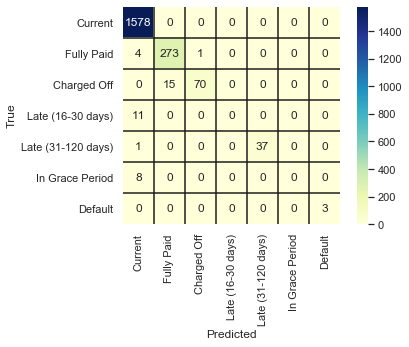

In [46]:
cf_matrix = confusion_matrix(y_test,y_pred2, labels=y_test.unique())
X_axis_labels = y_test.unique()
Y_axis_labels = y_test.unique()
ax = sns.heatmap(cf_matrix, xticklabels=X_axis_labels, yticklabels=Y_axis_labels, annot=True, fmt="d", cmap="YlGnBu",square=True)
plt.xlabel("Predicted")
plt.ylabel("True")
ax.hlines(np.arange(1,7), *ax.get_xlim())
ax.vlines(np.arange(1,7), *ax.get_ylim())

## random forest

In [47]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True, False],
    'max_depth': [36, None],
    'max_features': ['sqrt'],
    'min_samples_leaf': [1, 2],
    'min_samples_split': [2, 10],
    'n_estimators': [10,40]
}
# Create a based model
rfc = RandomForestClassifier(random_state=42, verbose=0)
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rfc, param_grid = param_grid, 
                          cv = 10, n_jobs = -1, verbose = 3)


# Fit the random search model
_ = grid_search.fit(X_train_pca, y_train)

Fitting 10 folds for each of 32 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:   31.0s
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:   39.2s finished


In [48]:
print(grid_search.best_params_)
print('-------------------------------------')
print(grid_search.best_score_)
print('-------------------------------------')
print(grid_search.best_estimator_)
print('-------------------------------------')
# print(grid_search.cv_results_)
result_rfc_grid = grid_search.cv_results_

{'bootstrap': False, 'max_depth': 36, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 40}
-------------------------------------
0.9808749999999999
-------------------------------------
RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=36, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=40,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
-------------------------------------


In [49]:
#concat two dataframes for better visualization 
df_result_grid = pd.concat([pd.DataFrame(result_rfc_grid['mean_fit_time']),
                              pd.DataFrame(result_rfc_grid['mean_test_score'])],axis=1)

df_result_grid.columns = ['mean_fit_time','mean_test_score']  #naming the dataframe columns
df_result_grid['accuracy_time_ratio'] = df_result_grid['mean_test_score']/df_result_grid['mean_fit_time']
df_result_grid['params'] = result_rfc_grid['params']


In [56]:
# Grid search cv result sumary
index_accuracy = df_result_grid['mean_test_score'].idxmax()
index_ratio = df_result_grid['accuracy_time_ratio'].idxmax()
print("Highest accuracy model is: NO. {}: \n {}".format(index_accuracy, 
                                                     df_result_grid['params'][index_accuracy]))
print("Highest accuracy-time ratio model is: NO. {}: \n {}".format(index_ratio, 
                                                     df_result_grid['params'][index_ratio]))


Highest accuracy model is: NO. 21: 
 {'bootstrap': False, 'max_depth': 36, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 40}
Highest accuracy-time ratio model is: NO. 2: 
 {'bootstrap': True, 'max_depth': 36, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 10}


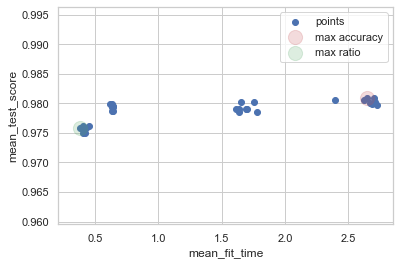

In [59]:
# visualize the cv result
plt.scatter(df_result_grid['mean_fit_time'], df_result_grid['mean_test_score'], c='b', label="points")
plt.scatter(df_result_grid['mean_fit_time'][index_accuracy], df_result_grid['mean_test_score'][index_accuracy], c='r', s=200, alpha=0.2, label='max accuracy')
plt.scatter(df_result_grid['mean_fit_time'][index_ratio], df_result_grid['mean_test_score'][index_ratio], c='g', s=200, alpha=0.2, label='max ratio')
plt.xlabel('mean_fit_time')
plt.ylabel('mean_test_score')
plt.legend()

### Evaluation on the test set (hold-out data)
Since the dataset is not very huge. We choose the model with hyperparameters give highest accuracy for evaluation.

In [60]:
# Create the final RF classifier

# parameter = {'n_estimators': 40, 
#              'min_samples_split': 2,
#              'min_samples_leaf': 1,
#              'max_features': 'sqrt',
#              'max_depth': 36, 
#              'bootstrap': False}
parameter = df_result_grid['params'][index_accuracy]

# Create a based model
rfc = RandomForestClassifier(**parameter, random_state=42, verbose=1, n_jobs=-1)
_ = rfc.fit(X_train_pca, y_train)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.2s finished


In [61]:
#Import scikit-learn metrics module for accuracy calculation
# from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

y_pred=rfc.predict(X_test_pca)

print('classification_report')
print(classification_report(y_test,y_pred))
print('----------------------------')
print('accuracy_score')
print(accuracy_score(y_test, y_pred))

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  40 out of  40 | elapsed:    0.0s finished


classification_report
                    precision    recall  f1-score   support

       Charged Off       1.00      0.84      0.91        85
           Current       0.99      1.00      1.00      1578
           Default       1.00      1.00      1.00         3
        Fully Paid       0.96      1.00      0.98       278
   In Grace Period       0.00      0.00      0.00         8
 Late (16-30 days)       0.80      0.73      0.76        11
Late (31-120 days)       0.90      0.97      0.94        38

          accuracy                           0.99      2001
         macro avg       0.81      0.79      0.80      2001
      weighted avg       0.98      0.99      0.98      2001

----------------------------
accuracy_score
0.9855072463768116


C:\Users\kefei\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


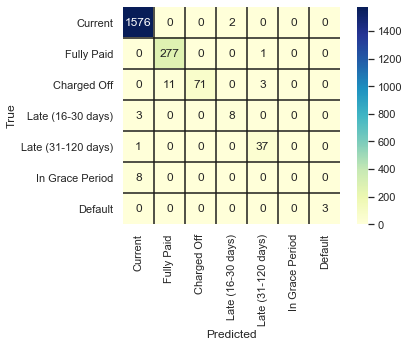

In [62]:
cf_matrix = confusion_matrix(y_test,y_pred, labels=y_test.unique())
X_axis_labels = y_test.unique()
Y_axis_labels = y_test.unique()
ax = sns.heatmap(cf_matrix, xticklabels=X_axis_labels, yticklabels=Y_axis_labels, annot=True, fmt="d", cmap="YlGnBu",square=True)
plt.xlabel("Predicted")
plt.ylabel("True")
ax.hlines(np.arange(1,7), *ax.get_xlim())
ax.vlines(np.arange(1,7), *ax.get_ylim())

# Write-up
Do the write-up analysis and conclusions, make sure that you include time execution for the models.

In this challenge, the task is a classification problem. We are working on the loan payment dataset, which has 100+ featues with both continous and categorical data. The dataset has 400,000+ records. The target is to predict loan payment status, i.e. "current", "fully Paid", "Charged Off" using historical data.
The goal of this challenge is to get familar with the machine learning procedure. We went through the whole process from data loading to model prep to model evaluation. 
Besides getting familiar with the procedure we also compare different popular approaches and models for supervised learning. The focus here is the comparison on:
- feature engineering, i.e. SelectKBest method, PCA methods
- hyper parameter specification, using grid search cross validation method/random search method
- decision tree model vs. random forest model.

### feature engineering sumary
- SelectKbest method has more straightforward workflow and higher accuracy (test on random forest model with default hyper-parameter using cross validation). 
- The burden for PCA is data preparation, i.e. only work well on continous-type data, need to standarized, need to handel high collinear feature pairs.
- I recommend using KselectBest for tree-type model data preparation, due to its simplacity and high-accuracy.
- For the future work of this part, I would like to work on the feature reduction algorithm. Note that, in this challenge, I manually set k=50 for the best feature threshold. I am thinking mimicing PCA variance, and find the "knee point" to determine the K best number.

### model comparison: decision tree vs. random forest
- The comparison is performed using same training data and evaluate on the same test data.
- In general, random forest model has better performanced over decision tree in accuracy, but in the cost of computation time, especially when the training/test data is large and/or the number of cross validation folder is large. Also, random forest is less likely to overfit.
- I recommed use random forest model over decision tree, especially when accuracy and avoiding overfitting is the priority. After all, time-efficiency is not decision tree strong end either. If time is really a concern, we might sort to other method.

### hyper parameter specification
- In the challenge, I performed random search cross validation and grid search scross validation.
- In my opinion, the puprose of grid search cv is not only finding the "best" hyper-parameters but also a way to evaluate the model with more cross validation cases. So that we can bestly avoid overfitting.
- When choosing the "best" hyper parameter, I consider both the accuracy and time-efficiency performance. 
- For future work in this part, I am considering more resonable way to evaluate accuracy-time ratio.